<a href="https://colab.research.google.com/github/nika-va/practice/blob/main/06_transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Oct  5 17:03:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-05 17:03:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-05 17:03:20 (94.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2023-10-05 17:03:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.4MB/s    in 72s     

2023-10-05 17:04:36 (21.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [6]:
# walk_through_dir('101_food_classes_10_percent')

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE,
                                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
checkpoint_path = 'food101_checkpoint/checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [9]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1/255.),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

In [10]:
from keras.src.engine.sequential import training
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

food_model = tf.keras.Model(inputs, outputs)

food_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics='accuracy')

16705208/16705208 [==============================] - 2s 0us/step


In [11]:
food_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [12]:
food_model_history = food_model.fit(train_data_all_10_percent,
                                    epochs=5,
                                    validation_data=test_data_all_10_percent,
                                    validation_split=int(0.15*len(test_data_all_10_percent)),
                                    callbacks=checkpoint)

Epoch 1/5
237/237 [==============================] - 160s 611ms/step - loss: 3.3572 - accuracy: 0.2789 - val_loss: 2.3026 - val_accuracy: 0.4796
Epoch 2/5
237/237 [==============================] - 120s 507ms/step - loss: 2.1992 - accuracy: 0.4954 - val_loss: 1.8812 - val_accuracy: 0.5331
Epoch 3/5
237/237 [==============================] - 110s 464ms/step - loss: 1.8095 - accuracy: 0.5686 - val_loss: 1.7170 - val_accuracy: 0.5575
Epoch 4/5
237/237 [==============================] - 114s 480ms/step - loss: 1.6066 - accuracy: 0.6121 - val_loss: 1.6418 - val_accuracy: 0.5683
Epoch 5/5
237/237 [==============================] - 103s 433ms/step - loss: 1.4334 - accuracy: 0.6506 - val_loss: 1.5968 - val_accuracy: 0.5770


In [13]:
food_model_results = food_model.evaluate(test_data_all_10_percent)
food_model_results

790/790 [==============================] - 57s 72ms/step - loss: 1.5968 - accuracy: 0.5770


[1.5967624187469482, 0.5770297050476074]

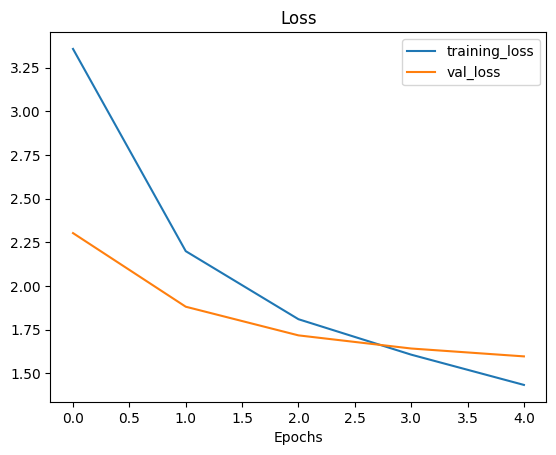

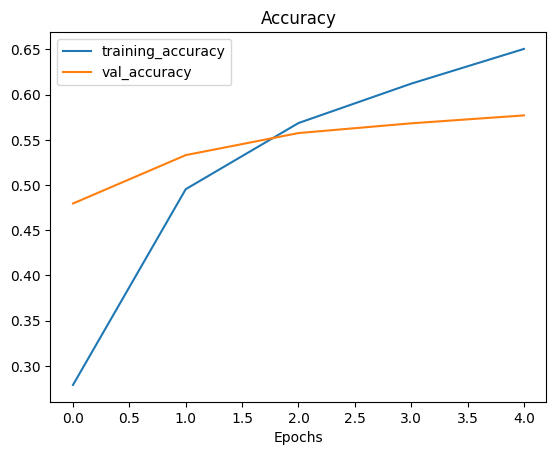

In [16]:
plot_loss_curves(food_model_history)

In [34]:
# Fine-tuning

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

food_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics='accuracy')

In [36]:
fine_tuned_food_model_history = food_model.fit(train_data_all_10_percent,
                                               epochs=5,
                                               validation_data=test_data_all_10_percent,
                                               validation_split=int(0.15*len(test_data_all_10_percent)))

Epoch 1/5
237/237 [==============================] - 106s 419ms/step - loss: 1.2011 - accuracy: 0.6869 - val_loss: 1.5260 - val_accuracy: 0.5901
Epoch 2/5
237/237 [==============================] - 97s 408ms/step - loss: 1.0854 - accuracy: 0.7083 - val_loss: 1.5152 - val_accuracy: 0.5929
Epoch 3/5
237/237 [==============================] - 93s 389ms/step - loss: 1.0083 - accuracy: 0.7317 - val_loss: 1.5319 - val_accuracy: 0.5910
Epoch 4/5
237/237 [==============================] - 93s 391ms/step - loss: 0.9514 - accuracy: 0.7415 - val_loss: 1.5055 - val_accuracy: 0.5979
Epoch 5/5
237/237 [==============================] - 92s 387ms/step - loss: 0.8785 - accuracy: 0.7626 - val_loss: 1.5124 - val_accuracy: 0.5971
